In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_excel('/content/df.xlsx')

In [ ]:
from sklearn.model_selection import train_test_split
                                                         
train_data, test_data = train_test_split(df, test_size=0.25, random_state=0)

In [ ]:
train_data.drop_duplicates(subset=['발화'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
print(len(train_data))
print(len(test_data))

750
250


In [ ]:
print(train_data.isnull().values.any()) # Null 값 확인
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

print('전처리 후 테스트용 샘플의 개수 :',len(train_data))

False
전처리 후 테스트용 샘플의 개수 : 750


In [ ]:
train_data['발화'] = train_data['발화'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거

train_data[:5]

,발화,코드
253,안내사항 설명하는방법을 개선했으면 함,4
667,친절한 상담에 감사드립니다,1
85,연결하는 대기시간 너무길다,5
969,카드는 상담하면 기분이 나뻐집니다 ㅋ삼성은 좋아요,23
75,통화대기시간이 매우길다,5


In [ ]:
test_data.drop_duplicates(subset = ['발화'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['발화'] = test_data['발화'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['발화'] = test_data['발화'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['발화'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 250


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [ ]:
# 토큰화

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 사전

In [ ]:
# 토근화 실행
!python -m pip install --upgrade konlpy
import konlpy

     |████████████████████████████████| 19.4 MB 1.5 MB/s 
     |████████████████████████████████| 448 kB 41.2 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
 # 형태소 분석 + stem = True 정규화

from konlpy.tag import Okt  
okt=Okt()

X_train = []
for sentence in train_data['발화']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [ ]:
X_train[:10]

[['안내', '사항', '설명', '방법', '을', '개선', '함'],
 ['친절하다', '상담', '감사', '드리다'],
 ['연결하다', '대기', '시간', '너무', '길다'],
 ['카드', '상담', '기분', '나쁘다', '지다', 'ㅋ', '삼성', '좋다'],
 ['통화', '대기', '시간', '매우', '길다'],
 ['매우', '친절하다', '감사하다'],
 ['상담', '친절하다', '받다', '감사하다'],
 ['연', '회비', '너무', '부담', '되다'],
 ['삼', '성', '전자', '부장', '님', '친절하다', '설명', '해주다', '감사', '드리다', '김치냉장고', '구입'],
 ['골드', '회원', '전용전', '화', '상담', '원', '비치', '되어다', '으', '면', '좋다']]

In [ ]:
# 테스트 데이터
X_test = []
for sentence in test_data['발화']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [ ]:
# 정수 인코딩

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])
print(tokenizer.word_index)

[[38, 131, 39, 111, 7, 208, 102], [2, 1, 15, 19], [115, 21, 10, 4, 33]]
{'상담': 1, '친절하다': 2, '감사하다': 3, '너무': 4, '해주다': 5, '연결': 6, '을': 7, '좋다': 8, '원': 9, '시간': 10, '통화': 11, '되다': 12, '카드': 13, '화면': 14, '감사': 15, '직원': 16, '친절': 17, '있다': 18, '드리다': 19, '고객': 20, '대기': 21, '상담사': 22, '없다': 23, '불편하다': 24, '전화': 25, '받다': 26, '처리': 27, '로': 28, '연': 29, '되어다': 30, '터치': 31, '정확하다': 32, '길다': 33, '회비': 34, '않다': 35, '때': 36, '보이다': 37, '안내': 38, '설명': 39, '다': 40, '다른': 41, '빠르다': 42, '삼성': 43, '내용': 44, '까지': 45, '에서': 46, '답변': 47, '같다': 48, '많이': 49, '분': 50, '바로': 51, '응대': 52, '대': 53, '기': 54, '모르다': 55, '적': 56, '시': 57, '요': 58, '질문': 59, '더': 60, '기분': 61, '성': 62, '면': 63, '어렵다': 64, '회사': 65, '사': 66, '서비스': 67, '매우': 68, '아니다': 69, '삼': 70, '비싸다': 71, '기다': 72, '과의': 73, '하': 74, '하고': 75, '음성': 76, '무': 77, '이자': 78, '안되다': 79, '자다': 80, '보다': 81, '것': 82, '생각': 83, '번': 84, '짧다': 85, '할부': 86, '기다리다': 87, '만': 88, '문의': 89, '말투': 90, '넘다': 91, '앱': 92, '선택': 93, '빨리': 9

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1103
등장 빈도가 1번 이하인 희귀 단어의 수: 616
단어 집합에서 희귀 단어의 비율: 55.84768812330009
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 10.947218766660743


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_data['코드'])
y_test = to_categorical(test_data['코드'])

In [ ]:
len(y_train[1])

44

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

750
750


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


발화의 최대 길이 : 73
발화의 평균 길이 : 7.502666666666666


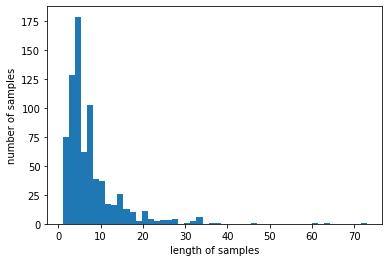

In [ ]:
# 패딩 - 길이 맞추기

print('발화의 최대 길이 :',max(len(l) for l in X_train))
print('발화의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 샘플 길이에 따른 비율 확인
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 98.13333333333333


In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 98.13333333333333


In [ ]:
# 발화 길이 30으로 맞추기
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
model = Sequential()
model.add(Embedding(1104, 100))
model.add(LSTM(128))
model.add(Dense(44, activation='softmax'))

In [ ]:
# 검증 데이터 손실 4회 증가하면 과적합 징후로 학습 조기 종료,ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
#다중 클래스 분류(Multi-Class Classification) 문제이므로 손실 함수로는 categorical_crossentropy를 사용
# categorical_crossentropy는 모델의 예측값과 실제값에 대해서 두 확률 분포 사이의 거리를 최소화하도록 훈련
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
h = model.fit(X_train, y_train, batch_size=60, epochs=15, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/15
13/13 [==============================] - 6s 134ms/step - loss: 3.4037 - acc: 0.2613 - val_loss: 2.6592 - val_acc: 0.2920

Epoch 00001: val_acc improved from -inf to 0.29200, saving model to best_model.h5
Epoch 2/15
13/13 [==============================] - 1s 89ms/step - loss: 2.2814 - acc: 0.3173 - val_loss: 2.3367 - val_acc: 0.2920

Epoch 00002: val_acc did not improve from 0.29200
Epoch 3/15
13/13 [==============================] - 1s 86ms/step - loss: 2.0741 - acc: 0.2827 - val_loss: 2.2544 - val_acc: 0.3040

Epoch 00003: val_acc improved from 0.29200 to 0.30400, saving model to best_model.h5
Epoch 4/15
13/13 [==============================] - 1s 87ms/step - loss: 1.9714 - acc: 0.3400 - val_loss: 2.1324 - val_acc: 0.3200

Epoch 00004: val_acc improved from 0.30400 to 0.32000, saving model to best_model.h5
Epoch 5/15
13/13 [==============================] - 1s 85ms/step - loss: 1.8145 - acc: 0.4253 - val_loss: 1.9532 - val_acc: 0.5240

Epoch 00005: val_acc improved from 0.

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

8/8 [==============================] - 2s 19ms/step - loss: 1.1170 - acc: 0.7360

 테스트 정확도: 0.7360
